In [1]:
import numpy as np
import pandas as pd
import re

from news_text_clean import *

import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator,DateFormatter,MonthLocator,YearLocator

Using TensorFlow backend.


In [2]:
def topic_classification(text):
    # Function to identify topic from a given text
    # topic_list will be: ['ICO','bitcoin','currency,currenc'] 
    # Each topic can have multiple key words separated by comma. E.g: currency,currenc
    
    topic_xl = pd.read_excel('data/topic_list.xlsx')
    topic_list = topic_xl['Keywords'].tolist()
    
    topic_out = []
    for topic in topic_list:
        dup_names = topic.split(',')
        for name in dup_names:
            if name.lower() in text.lower():
                topic_out.append(dup_names[0])
                break
    
    # Check for empty list
    if not topic_out:
        topic_out = np.nan 
                
    return topic_out


In [3]:
# Import and clean the data
data = pd.read_json('data/data_all_2600.json')
data = news_text_clean(data)

# Identify the topic
data['topic'] = data['title'].apply(topic_classification)

# Drop rows which do not have topic
data.dropna(subset=['topic'], inplace=True)

# Load sentiment model
max_words = 500

model = load_model('model_content_1.h5')
tokeniz = pickle.load(open('tokenizer_content_1.p','rb')) # Load presaved tokenizer

X_data = tokeniz.texts_to_sequences(data['contents'].values)
X_data = pad_sequences(X_data, maxlen=max_words, truncating='post')

Y_prob = model.predict(X_data)

Y_class = np.argmax(Y_prob, axis=1)-1

data['Sentiment'] = Y_class

In [6]:
print(data.loc[10,:]) # Sample data

author                                             Stan Higgins
checksum      2da8beb646993e71495d6a1fbf73ffbd004f2ad91b28a9...
contents      Major insurance groups AIG and AIA are among  ...
created_at                           2017-10-04 09:56:18.079000
date                                        2017-10-02 22:00:56
id                                                          137
link          https://www.coindesk.com/aia-aig-join-b3i-bloc...
provider                                               CoinDesk
tags                  [Insurance, consortium, reinsurance, B3i]
title         AIA and AIG Join Bi as Blockchain Consortium A...
updated_at                           2017-10-04 09:56:18.079000
topic                                              [blockchain]
Sentiment                                                     1
Name: 10, dtype: object


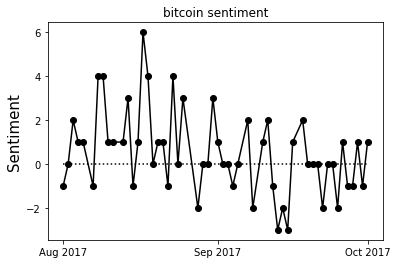

In [5]:
# User input
usr_topic = 'bitcoin'
usr_startDate = '2017-08-01'
usr_endDate = '2017-10-01'

format_startTime = datetime.strptime(usr_startDate, "%Y-%m-%d") #This converts STRING to date object with time
startDate = format_startTime.date() # This removes time
endDate = datetime.strptime(usr_endDate, "%Y-%m-%d").date()

period=endDate-startDate

# Initialize scores
score={}
count={}
for i in range(period.days+1):
    score[(startDate + timedelta(days=i))]=0
    count[(startDate + timedelta(days=i))]=0

# Calculating scores
for i in range(len(data)):
    
    if ( (data.iloc[i]['date'].date()>=startDate) and 
         (data.iloc[i]['date'].date()<=endDate)):
        
        topic_list = [x.lower() for x in data.iloc[i]['topic']]
        if (usr_topic.lower() in topic_list):
            score[data.iloc[i]['date'].date()] = score[data.iloc[i]['date'].date()] + data.iloc[i]['Sentiment']
            count[data.iloc[i]['date'].date()]+=1
    

for i in range(period.days+1):
    if not (count[(startDate + timedelta(days=i))]):
        del score[(startDate + timedelta(days=i))]

    
list_score = sorted(score.items()) # sorted by key, return a list of tuples
x, y = zip(*list_score) # unpack a list of pairs into two tuples

y_zero = np.zeros((len(x),1))

fig, ax = plt.subplots(ncols=1)
ax.plot(x,y,marker='o',c='k', ls='-')
ax.plot(x,y_zero,':k')


if (period.days<7):
    ax.xaxis.set_major_locator(DayLocator(interval=1))#MonthLocator/DateLocator
    ax.xaxis.set_major_formatter(DateFormatter('%d %b'))
elif (period.days<30):
    ax.xaxis.set_major_locator(DayLocator(interval=5))
    ax.xaxis.set_major_formatter(DateFormatter('%d %b'))
elif (period.days<180):
    ax.xaxis.set_major_locator(MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
elif (period.days<365):
    ax.xaxis.set_major_locator(MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
else:
    ax.xaxis.set_major_locator(YearLocator(interval=1))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    
ax.set_ylabel('Sentiment', fontsize=15)
ax.set_title(usr_topic+' sentiment')
plt.show()

# Explanation
In this final script, the sentiment of the public towards cryptocurrencies is tracked. Most (95%) of the Coindesk articles are related to a small list of topics given in "topic_list.xlsx". First, a simple function (topic_classification(text)) can be used to determine the topic of a given news article from this small list. Second, the CNN model, trained in the 2nd IPython notebook, can be used to determine the sentiment of news articles. Finally, the sentiment of news articles related to a particular topic (e.g. Bitcoin) can be tracked within a given period.